# Sortify

The goal is to automatically pre-sort the playlists I regularly create for the Rock 4 Temps club parties I'm part of.

Main objectives:
* Play first the most known musics
* Alternate slow and fast music

Secondary objectives:
* Display a histogram of bpm, ideally the majority should be close to 120 (for this type of dance)
* Display the "Title - Artist" list to easily generate the PDF for the evening.

Spotify API Documentation cheatsheet:
* https://developer.spotify.com/documentation/web-api/reference/get-audio-analysis
* https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features

## Get tracks

In [79]:
import os

import spotipy
from spotipy.oauth2 import SpotifyOAuth

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import date
from collections import Counter

### Parameters

In [80]:
# Parameters

c_id = os.environ['c_id']
c_secret = os.environ['c_secret']

ven_1 = "68O2vo8oxeVoVJLKOco9zQ"
dim_1 = "3UztL2Q5ygho1Aioi5BWKj"
dim_2 = "0L1FfvCLCukui1dmOXoYOt"

#playlist_id = "4qLLNwdJSnQvIAgLne0TkG" 
playlist_id = dim_2


# allow to ignore the N last musics 
ignore_last = 0
apply_reorder = True

In [81]:
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=c_id,
                                               client_secret=c_secret,
                                               redirect_uri="https://127.0.0.1",
                                               scope="""
                                               playlist-read-private playlist-modify-private playlist-modify-public 
                                               playlist-read-collaborative user-library-modify"""))

results = sp.current_user_playlists(limit=50)

# Find playlist_id if not specified

if not playlist_id:
    for playlist in results['items']:
        print(playlist['name'], playlist['id'])

In [82]:
playlist_tracks = sp.user_playlist_tracks(playlist_id=playlist_id)

In [83]:
print(playlist_tracks['items'][0].keys())
print(playlist_tracks['items'][0]['track'].keys())
print(playlist_tracks['items'][0]['track']['album'].keys())

dict_keys(['added_at', 'added_by', 'is_local', 'primary_color', 'track', 'video_thumbnail'])
dict_keys(['preview_url', 'available_markets', 'explicit', 'type', 'episode', 'track', 'album', 'artists', 'disc_number', 'track_number', 'duration_ms', 'external_ids', 'external_urls', 'href', 'id', 'name', 'popularity', 'uri', 'is_local'])
dict_keys(['available_markets', 'type', 'album_type', 'href', 'id', 'images', 'name', 'release_date', 'release_date_precision', 'uri', 'artists', 'external_urls', 'total_tracks'])


In [84]:
def playlist_tracks_to_df(playlist_tracks):
    tracks = []
    for track in playlist_tracks['items']:
        t = track['track']
        features = sp.audio_analysis(t['id'])
        track = {
            'id': t['id'],
            'name': t['name'],
            'artist': ', '.join([artist['name'] for artist in t['artists']]),
            'duration_ms': t['duration_ms'],
            'explicit': t['explicit'],
            'release_date': t['album']['release_date'],
            'popularity': t['popularity'],
        }

        tracks.append(track)
    df = pd.DataFrame(tracks)
    return df

df = playlist_tracks_to_df(playlist_tracks)
df

,id,name,artist,duration_ms,explicit,release_date,popularity
0,5yDL13y5giogKs2fSNf7sj,Glad You Came,The Wanted,197935,False,2011-01-01,78
1,1qEmFfgcLObUfQm0j1W2CK,Late Night Talking,Harry Styles,177954,False,2022-05-20,83
2,4i2qxFEVVUi8yOYoxB8TCX,Midnight Sky,Miley Cyrus,223280,False,2020-11-27,73
3,3p7XQpdt8Dr6oMXSvRZ9bg,Eyes Closed,Ed Sheeran,194848,False,2023-05-05,78
4,58UKC45GPNTflCN6nwCUeF,Fancy Like,Walker Hayes,161853,False,2022-01-21,72
5,3Pj6u2KTgepyyidp5xfbHp,Ashes,Stellar,166355,True,2020-05-03,73
6,1nahzW3kfMuwReTka28tH5,Hold On,Justin Bieber,170813,False,2021-03-19,71
7,37ZtpRBkHcaq6hHy0X98zn,I CAN'T STOP ME,TWICE,205493,False,2020-10-26,72
8,6ErCfbbI9BG4bK2djjKUvP,i wish you cheated,Alexander Stewart,190626,False,2023-08-09,68
9,51Of5p3lKZeOg6itfs4og4,Lovefool,twocolors,190487,False,2020-05-08,69


## Get audio features

In [85]:
features = pd.DataFrame(sp.audio_features(tracks=df['id']))
for col in ['energy', 'mode', 'tempo']:
    df[col] = features[col]
df

,id,name,artist,duration_ms,explicit,release_date,popularity,energy,mode,tempo
0,5yDL13y5giogKs2fSNf7sj,Glad You Came,The Wanted,197935,False,2011-01-01,78,0.851,0,126.885
1,1qEmFfgcLObUfQm0j1W2CK,Late Night Talking,Harry Styles,177954,False,2022-05-20,83,0.728,1,114.996
2,4i2qxFEVVUi8yOYoxB8TCX,Midnight Sky,Miley Cyrus,223280,False,2020-11-27,73,0.805,0,109.976
3,3p7XQpdt8Dr6oMXSvRZ9bg,Eyes Closed,Ed Sheeran,194848,False,2023-05-05,78,0.526,1,107.071
4,58UKC45GPNTflCN6nwCUeF,Fancy Like,Walker Hayes,161853,False,2022-01-21,72,0.765,1,79.994
5,3Pj6u2KTgepyyidp5xfbHp,Ashes,Stellar,166355,True,2020-05-03,73,0.568,0,130.019
6,1nahzW3kfMuwReTka28tH5,Hold On,Justin Bieber,170813,False,2021-03-19,71,0.634,0,140.002
7,37ZtpRBkHcaq6hHy0X98zn,I CAN'T STOP ME,TWICE,205493,False,2020-10-26,72,0.880,0,150.084
8,6ErCfbbI9BG4bK2djjKUvP,i wish you cheated,Alexander Stewart,190626,False,2023-08-09,68,0.487,1,77.141
9,51Of5p3lKZeOg6itfs4og4,Lovefool,twocolors,190487,False,2020-05-08,69,0.766,1,123.062


In [86]:
# See current order.

def reload_order():
    playlist_tracks = sp.user_playlist_tracks(playlist_id=playlist_id)
    df = playlist_tracks_to_df(playlist_tracks)
    features = pd.DataFrame(sp.audio_features(tracks=df['id']))
    for col in ['energy', 'mode', 'tempo']:
        df[col] = features[col]
    return df

#df = reload_order()
df

,id,name,artist,duration_ms,explicit,release_date,popularity,energy,mode,tempo
0,5yDL13y5giogKs2fSNf7sj,Glad You Came,The Wanted,197935,False,2011-01-01,78,0.851,0,126.885
1,1qEmFfgcLObUfQm0j1W2CK,Late Night Talking,Harry Styles,177954,False,2022-05-20,83,0.728,1,114.996
2,4i2qxFEVVUi8yOYoxB8TCX,Midnight Sky,Miley Cyrus,223280,False,2020-11-27,73,0.805,0,109.976
3,3p7XQpdt8Dr6oMXSvRZ9bg,Eyes Closed,Ed Sheeran,194848,False,2023-05-05,78,0.526,1,107.071
4,58UKC45GPNTflCN6nwCUeF,Fancy Like,Walker Hayes,161853,False,2022-01-21,72,0.765,1,79.994
5,3Pj6u2KTgepyyidp5xfbHp,Ashes,Stellar,166355,True,2020-05-03,73,0.568,0,130.019
6,1nahzW3kfMuwReTka28tH5,Hold On,Justin Bieber,170813,False,2021-03-19,71,0.634,0,140.002
7,37ZtpRBkHcaq6hHy0X98zn,I CAN'T STOP ME,TWICE,205493,False,2020-10-26,72,0.880,0,150.084
8,6ErCfbbI9BG4bK2djjKUvP,i wish you cheated,Alexander Stewart,190626,False,2023-08-09,68,0.487,1,77.141
9,51Of5p3lKZeOg6itfs4og4,Lovefool,twocolors,190487,False,2020-05-08,69,0.766,1,123.062


In [87]:
df.to_csv("tmp_result.csv")

## Sort / Reindex

In [88]:
if not apply_reorder:
    result = df

if ignore_last:
    ignored = df.iloc[-ignore_last:]
    df = df.iloc[:-ignore_last]
    print("not sorting:", ignored[['name', 'artist']])

In [89]:
median_energy = np.median(df['energy'])

print(median_energy)

df = df.sort_values('popularity', ascending=False).reset_index(drop=True)

df_inf_median = df[df["energy"] < median_energy]
df_sup_median = df[df["energy"] >= median_energy]

print(df_inf_median.shape)
print(df_sup_median.shape)

0.7605
(12, 10)
(12, 10)


In [90]:
ids_ordered = []

for id1, id2 in zip(df_sup_median['id'].values, df_inf_median['id'].values):
    ids_ordered.append(id1)
    ids_ordered.append(id2)

if df_inf_median.shape[0] > df_sup_median.shape[0]:
    ids_ordered.append(df_inf_median['id'].iloc[-1])
elif df_inf_median.shape[0] < df_sup_median.shape[0]:
    ids_ordered.append(df_sup_median['id'].iloc[-1])

In [91]:
if ignore_last:
    for idx in ignored['id']:
        ids_ordered.append(idx)

## Replace in Playlist

In [92]:
if apply_reorder:
    sp.playlist_replace_items(playlist_id, ids_ordered)

## See result & Generate PDF

In [93]:
df[['name', 'artist', 'energy', 'energy', 'tempo']].to_csv("export_28_04")

In [94]:
if apply_reorder:
    if ignore_last:
        df = pd.concat([df, ignored])
    result = df.set_index("id")
    result = result.reindex(ids_ordered)
result

,name,artist,duration_ms,explicit,release_date,popularity,energy,mode,tempo
id,,,,,,,,,
5yDL13y5giogKs2fSNf7sj,Glad You Came,The Wanted,197935,False,2011-01-01,78,0.851,0,126.885
1qEmFfgcLObUfQm0j1W2CK,Late Night Talking,Harry Styles,177954,False,2022-05-20,83,0.728,1,114.996
4i2qxFEVVUi8yOYoxB8TCX,Midnight Sky,Miley Cyrus,223280,False,2020-11-27,73,0.805,0,109.976
3p7XQpdt8Dr6oMXSvRZ9bg,Eyes Closed,Ed Sheeran,194848,False,2023-05-05,78,0.526,1,107.071
58UKC45GPNTflCN6nwCUeF,Fancy Like,Walker Hayes,161853,False,2022-01-21,72,0.765,1,79.994
3Pj6u2KTgepyyidp5xfbHp,Ashes,Stellar,166355,True,2020-05-03,73,0.568,0,130.019
37ZtpRBkHcaq6hHy0X98zn,I CAN'T STOP ME,TWICE,205493,False,2020-10-26,72,0.880,0,150.084
1nahzW3kfMuwReTka28tH5,Hold On,Justin Bieber,170813,False,2021-03-19,71,0.634,0,140.002
51Of5p3lKZeOg6itfs4og4,Lovefool,twocolors,190487,False,2020-05-08,69,0.766,1,123.062


In [95]:
result.sort_values(['tempo']).tail(15)

,name,artist,duration_ms,explicit,release_date,popularity,energy,mode,tempo
id,,,,,,,,,
3wuR0YSNdT9rgWfFi1lctv,Million Ways,HRVY,169887,False,2019-11-08,53,0.803,1,106.030
3ArdPRbscsYB2uI70AzpuG,All My Friends,Madeon,204613,False,2019-11-15,49,0.764,0,106.036
07OKKRUAmBaJDf8YGF1PD5,Do Me Like A Drug,Emmanuel Franco,172709,False,2020-01-08,39,0.757,1,106.985
3p7XQpdt8Dr6oMXSvRZ9bg,Eyes Closed,Ed Sheeran,194848,False,2023-05-05,78,0.526,1,107.071
7bREivF1RTm0vOYB2wi7nE,Distorted Light Beam,Bastille,177221,False,2021-06-23,46,0.820,0,107.953
4i2qxFEVVUi8yOYoxB8TCX,Midnight Sky,Miley Cyrus,223280,False,2020-11-27,73,0.805,0,109.976
6TrNRd98WksT9Kkmx9uj6R,Let It Rock,"Kevin Rudolf, Lil Wayne",231173,True,2008-01-01,67,0.783,1,113.172
1qEmFfgcLObUfQm0j1W2CK,Late Night Talking,Harry Styles,177954,False,2022-05-20,83,0.728,1,114.996
51Of5p3lKZeOg6itfs4og4,Lovefool,twocolors,190487,False,2020-05-08,69,0.766,1,123.062


In [96]:
# For easy copy pasting :)

def display(values):
    print(values[0], "-", values[1])

def display_bpm(values):
    emoji = "⚡ " if values[2] > 150 else ("🐢 " if values[2] < 105 else "")
    
    print(f"{emoji}{values[0].split('(')[0]} - {values[1]}")
    
#_ = result[['name', 'artist']].apply(display, axis=1)
_ = result[['name', 'artist', 'tempo']].apply(display_bpm, axis=1)

Glad You Came - The Wanted
Late Night Talking - Harry Styles
Midnight Sky - Miley Cyrus
Eyes Closed - Ed Sheeran
🐢 Fancy Like - Walker Hayes
Ashes - Stellar
⚡ I CAN'T STOP ME - TWICE
Hold On - Justin Bieber
Lovefool - twocolors
🐢 i wish you cheated - Alexander Stewart
Let It Rock - Kevin Rudolf, Lil Wayne
🐢 All Falls Down  - Alan Walker, Noah Cyrus, Digital Farm Animals, Juliander
🐢 Teach Me How To Love - Shawn Mendes
⚡ Cleopatra - Efendi
Million Ways - HRVY
🐢 Weddings & Funerals - Royal & the Serpent
All My Friends - Madeon
Do Me Like A Drug - Emmanuel Franco
Distorted Light Beam - Bastille
🐢 ICARUS - GRANT KNOCHE
Bad Love - Tokio Hotel
🐢 Heat Waves - Glass Animals
🐢 Kill the Time - Rachel Lorin, LiveLikeSage
🐢 Left & Right - Malou Prytz


# Statistics

## Alerts

In [97]:
def to_min(x):
    sec = x / 1000
    minutes = int(sec // 60)
    secondes = int(sec % 60)
    return f"{minutes}:{secondes}"
    
over4min = df[df['duration_ms'] > 4 * 60 * 1000 ]
if over4min.shape[0] > 0:
    print(f"* {over4min.shape[0]} musics over 4 minutes:")
    for i, (name, artist, ms) in enumerate(over4min[['name', 'artist', 'duration_ms']].values):
        print(f"\t{i+1}: {name} - {artist} ({to_min(ms)})")
    print()
    
expected_duration = ((2 * 60) + 10) * 60 * 1000 # 2h10
current_duration = df['duration_ms'].sum()
diff = expected_duration - current_duration
treshold = 5*60*1000

if diff > treshold:
    print(f"* Playlist too short. Add ~{to_min(diff - treshold)} of music.\n")
elif diff < treshold:
    print(f"* Playlist too long. Remove ~{to_min((diff + treshold))} of music.\n")
    
# TODO: dire quand plusieurs musiques du meme artiste

artists = []
for artist in result['artist'].values:
    if ',' in artist:
        for co_artist in artist.split(','):
            artists.append(co_artist.strip())
    else:
        artists.append(artist)
c = Counter(artists)
duplicated_artists = list(filter(lambda x: int(x[1]) > 1, c.most_common()))
if duplicated_artists:
    print("* Duplicated artists:")
    for artist, ntimes in duplicated_artists:
        print(f"  {ntimes}x {artist}")

* Playlist too short. Add ~50:44 of music.



## Informations

In [98]:
# Configure graphs style
mpl.style.use("fivethirtyeight")

In [99]:
print(f"* {round(df[df['explicit']].shape[0] / df.shape[0] * 100, 2)}% of explicit songs")

* 12.5% of explicit songs


<BarContainer object of 16 artists>

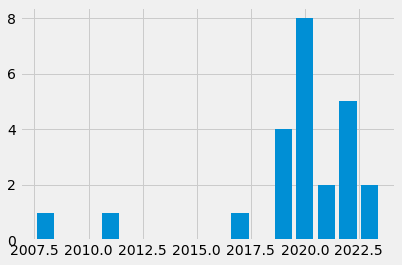

In [100]:
df['year'] = df['release_date'].apply(lambda x: x[:4])

hist = dict.fromkeys(range(int(df['year'].min()), int(df['year'].max()) + 1), 0)

def count_years(y):
    hist[int(y)] += 1

df['year'].apply(count_years)

fig, ax = plt.subplots()
ax.bar(hist.keys(), hist.values())

In [101]:
df.sort_values('tempo')

,id,name,artist,duration_ms,explicit,release_date,popularity,energy,mode,tempo,year
20,4flE50KratI5sjuZfrAYyi,ICARUS,GRANT KNOCHE,155327,False,2022-07-14,34,0.708,0,69.980,2022
9,6ErCfbbI9BG4bK2djjKUvP,i wish you cheated,Alexander Stewart,190626,False,2023-08-09,68,0.487,1,77.141,2023
5,58UKC45GPNTflCN6nwCUeF,Fancy Like,Walker Hayes,161853,False,2022-01-21,72,0.765,1,79.994,2022
22,02MWAaffLxlfxAUY7c5dvx,Heat Waves,Glass Animals,238805,False,2020-08-06,23,0.525,1,80.870,2020
23,0adtN7b1rfBWHRWgnUlR9m,Left & Right,Malou Prytz,169753,False,2019-05-24,23,0.603,0,92.022,2019
21,1JDkQ26HFKjcrt7KmOEHZZ,Kill the Time,"Rachel Lorin, LiveLikeSage",154176,True,2022-12-16,30,0.764,0,94.989,2022
17,5XGjHvW9kqp8QqFpMHmESt,Weddings & Funerals,Royal & the Serpent,176597,False,2019-04-26,43,0.581,0,96.640,2019
11,5yFSF6qQA1rcLsQRnBsZgb,All Falls Down (feat. Juliander),"Alan Walker, Noah Cyrus, Digital Farm Animals,...",199111,False,2017-10-27,62,0.678,1,97.976,2017
12,5LZtB6nxvjIhUoElp3Zqk0,Teach Me How To Love,Shawn Mendes,202356,False,2020-12-04,57,0.885,0,98.991,2020
13,3wuR0YSNdT9rgWfFi1lctv,Million Ways,HRVY,169887,False,2019-11-08,53,0.803,1,106.030,2019


count     24.000000
mean     109.411542
std       23.493429
min       69.980000
25%       96.227250
50%      107.028000
75%      123.538500
max      170.035000
Name: tempo, dtype: float64


<AxesSubplot:>

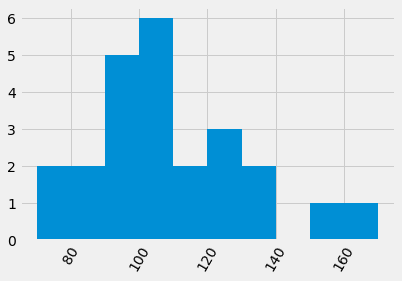

In [102]:
tempo = df['tempo'].sort_values()
print(tempo.describe())
tempo.hist(xrot=60)

<AxesSubplot:>

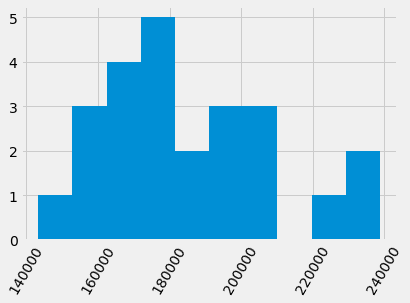

In [103]:
df['duration_ms'].sort_values().hist(xrot=60)